<a href="https://colab.research.google.com/github/jerryorajekwe/Predicting-Loan-Default-Risk-with-Machine-Learning-Models/blob/main/Loandefaultprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loan Default Prediction Model**

This script is designed to predict loan defaults using machine learning models.
It includes steps for:
1. Data preprocessing, including handling missing values, encoding categorical features, and dealing with outliers.
2. Resampling to address class imbalance using SMOTE.
3. Training and hyperparameter tuning for Logistic Regression, Random Forest, and XGBoost models.
4. Evaluating the models using metrics such as ROC-AUC, Accuracy, Precision, Recall, and F1-Score.
5. Visualizing feature importances and interpreting model results.

The goal is to identify the most effective model for predicting loan defaults while gaining insights from the data.

# **1. Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Libraries**

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for preprocessing and imputation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Libraries for model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# Additional utilities
from collections import Counter

# **3. Data Loading and** **sampling**

In [3]:
# Load the dataset
loan_data = pd.read_csv('/content/drive/MyDrive/loan.csv', low_memory=False)


In [4]:
# 30% random sample
loan_data_sample = loan_data.sample(frac=0.3, random_state=42)

In [5]:
# Save the sampled dataset
loan_data_sample.to_csv('loan_data_sample.csv', index=False)

# **4. Dataset Overview**

In [6]:
# Display information about the sampled dataset
print("Sampled Dataset Information:")
loan_data_sample.info()

Sampled Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 678200 entries, 1758049 to 2038627
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 755.4+ MB


In [7]:
print("First 5 Rows of the Dataset:")
loan_data_sample.head()

First 5 Rows of the Dataset:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1758049,NaN,NaN,35000,35000,35000.0,36 months,12.12,1164.51,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
686533,NaN,NaN,30000,30000,30000.0,60 months,10.75,648.54,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
900721,NaN,NaN,15000,15000,15000.0,36 months,7.49,466.53,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1727912,NaN,NaN,24000,24000,24000.0,60 months,21.15,651.31,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
539691,NaN,NaN,14400,14400,14400.0,36 months,8.59,455.18,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Table 1: Descriptive Statistics:")
loan_data_sample.describe().round(2)

Table 1: Descriptive Statistics:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,678200.00,678200.00,678200.00,678200.00,678200.00,678199.00,0.0,677684.00,...,3120.0,3120.00,3120.0,3120.00,2484.00,3120.00,3120.00,9997.00,9997.00,9997.00
mean,NaN,NaN,15063.79,15058.51,15040.42,13.10,446.30,77946.48,NaN,18.85,...,3.0,151.33,3.0,13.77,444.48,11385.30,194.32,5028.51,47.83,13.09
std,NaN,NaN,9189.32,9187.32,9191.01,4.83,267.19,74649.50,NaN,14.53,...,0.0,125.54,0.0,9.75,366.31,7421.83,201.58,3699.03,7.13,8.07
min,NaN,NaN,500.00,500.00,0.00,5.31,15.69,0.00,NaN,-1.00,...,3.0,1.61,3.0,0.00,10.17,193.98,0.01,107.00,0.45,0.00
25%,NaN,NaN,8000.00,8000.00,8000.00,9.49,251.98,46000.00,NaN,11.91,...,3.0,57.76,3.0,5.00,171.97,5531.34,43.69,2240.75,45.00,6.00
50%,NaN,NaN,13000.00,13000.00,12875.00,12.62,378.59,65000.00,NaN,17.85,...,3.0,116.40,3.0,15.00,344.52,9919.18,128.99,4179.00,45.00,14.00
75%,NaN,NaN,20000.00,20000.00,20000.00,15.99,593.82,93000.00,NaN,24.50,...,3.0,208.74,3.0,23.00,609.23,15698.72,286.32,6831.00,50.00,18.00
max,NaN,NaN,40000.00,40000.00,40000.00,30.99,1717.63,10999200.00,NaN,999.00,...,3.0,893.63,3.0,31.00,2680.89,40149.35,1275.36,30000.00,184.36,50.00


In [9]:
# Get the list of features
features = loan_data_sample.columns.tolist()
print(features)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_i

# **5. Data Prepocessing**

**5.1 Drop Unnecessary Columns**

In [10]:
# List of columns to drop
columns_to_drop = [
    'id', 'member_id', 'url', 'desc', 'title', 'zip_code',
    'addr_state', 'pymnt_plan', 'policy_code', 'hardship_flag',
    'debt_settlement_flag', 'debt_settlement_flag_date',
    'settlement_status', 'settlement_date', 'settlement_amount',
    'settlement_percentage', 'settlement_term'
]

# Drop the columns
loan_data_sample = loan_data_sample.drop(columns=columns_to_drop)

# Save the cleaned dataset
loan_data_sample.to_csv('loan_data_cleaned.csv', index=False)

In [11]:
# Display information about the cleaned dataset
print("Cleaned Dataset Information:")
loan_data_sample.info()

Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 678200 entries, 1758049 to 2038627
Columns: 128 entries, loan_amnt to disbursement_method
dtypes: float64(99), int64(3), object(26)
memory usage: 667.5+ MB


**5.2 Check for Duplicates**

In [12]:
# Number of duplicate records
loan_data_sample.duplicated().sum()

np.int64(0)

**5.3 Check for Missing Values**

In [13]:
# Missing values in each column
loan_data_sample.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
...,...
hardship_loan_status,675080
orig_projected_additional_accrued_interest,675716
hardship_payoff_balance_amount,675080
hardship_last_payment_amount,675080


**5.4 Handle Missing Values**

In [14]:
# Drop columns with high missing values
threshold = 0.5
columns_to_drop = loan_data_sample.columns[loan_data_sample.isnull().mean() > threshold]
loan_data_sample = loan_data_sample.drop(columns=columns_to_drop)

print(f"Dropped columns: {list(columns_to_drop)}")

Dropped columns: ['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount']


In [15]:
# Fill missing values for numerical columns
num_cols = loan_data_sample.select_dtypes(include=['float64', 'int64']).columns
loan_data_sample[num_cols] = loan_data_sample[num_cols].fillna(loan_data_sample[num_cols].median())

In [16]:
# Fill missing values for categorical columns
cat_cols = loan_data_sample.select_dtypes(include=['object']).columns
loan_data_sample[cat_cols] = loan_data_sample[cat_cols].fillna('Unknown')

**5.5 Save Cleaned Dataset**

In [17]:
# Save the dataset after handling missing values
loan_data_sample.to_csv('loan_data_cleaned.csv', index=False)

print("Missing values handled and dataset saved!")

Missing values handled and dataset saved!


# **6. Exploratory Data Analysis (EDA)**

**6.1 Numerical Feature Analysis**

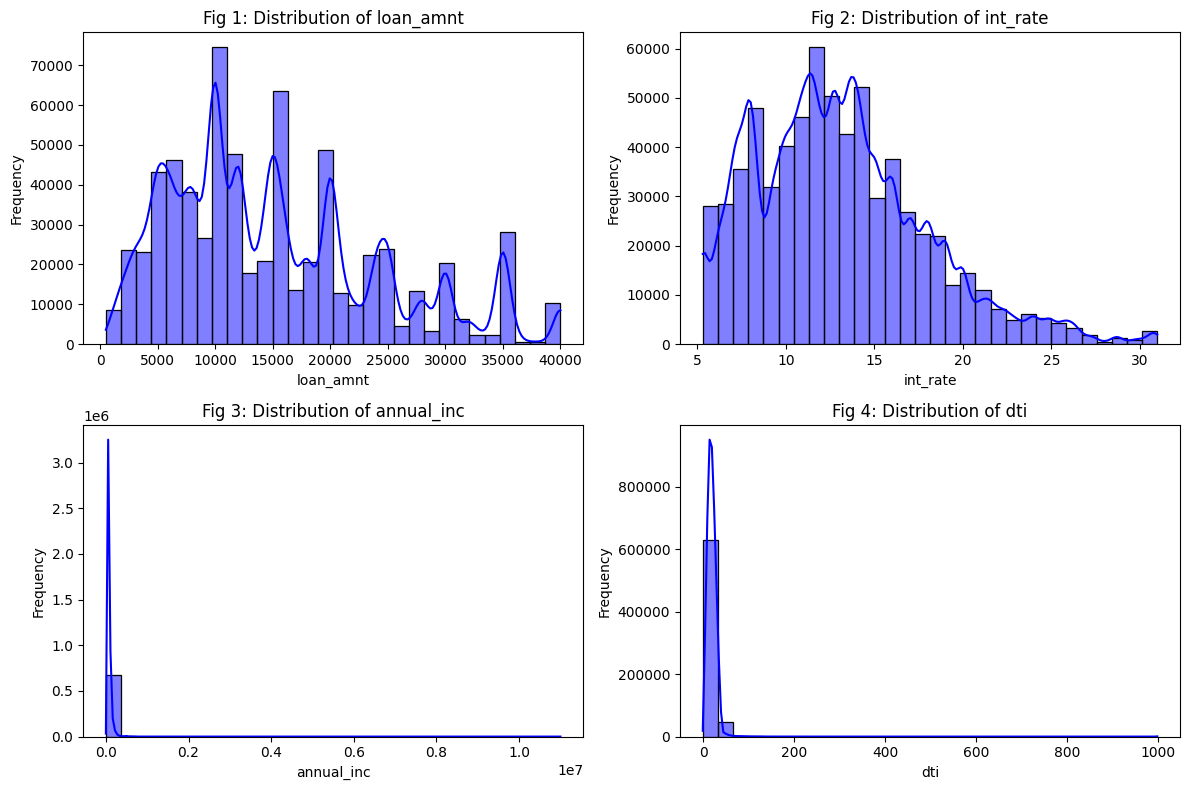

In [18]:
# List of numerical variables to analyze
num_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']

# Plot histograms with figure labels
plt.figure(figsize=(12, 8))
for i, var in enumerate(num_vars, 1):
    plt.subplot(2, 2, i)  # Create subplots
    sns.histplot(loan_data_sample[var], kde=True, bins=30, color='blue')
    plt.title(f'Fig {i}: Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**6.2 Categorical Feature Analysis**

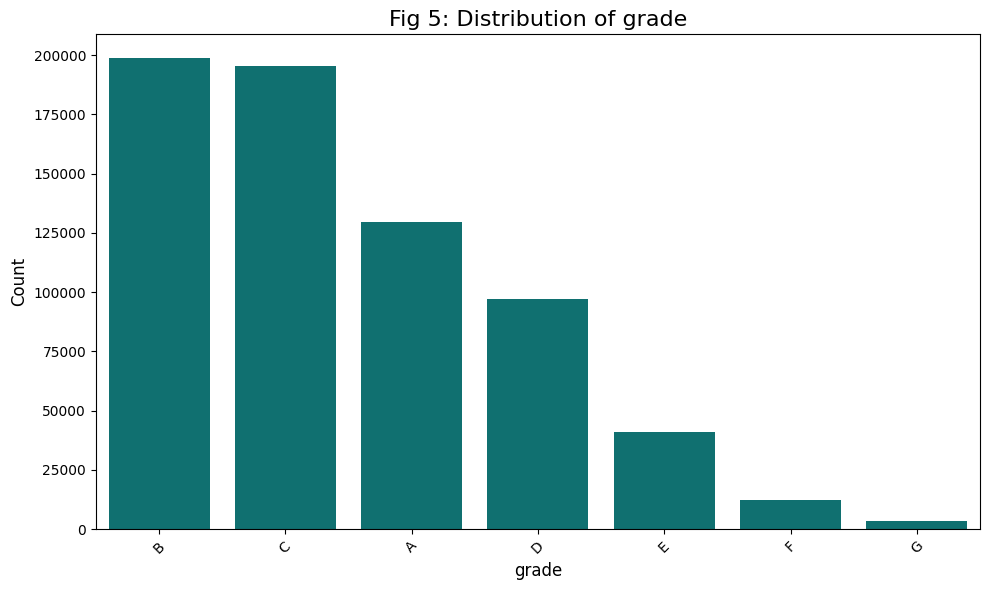

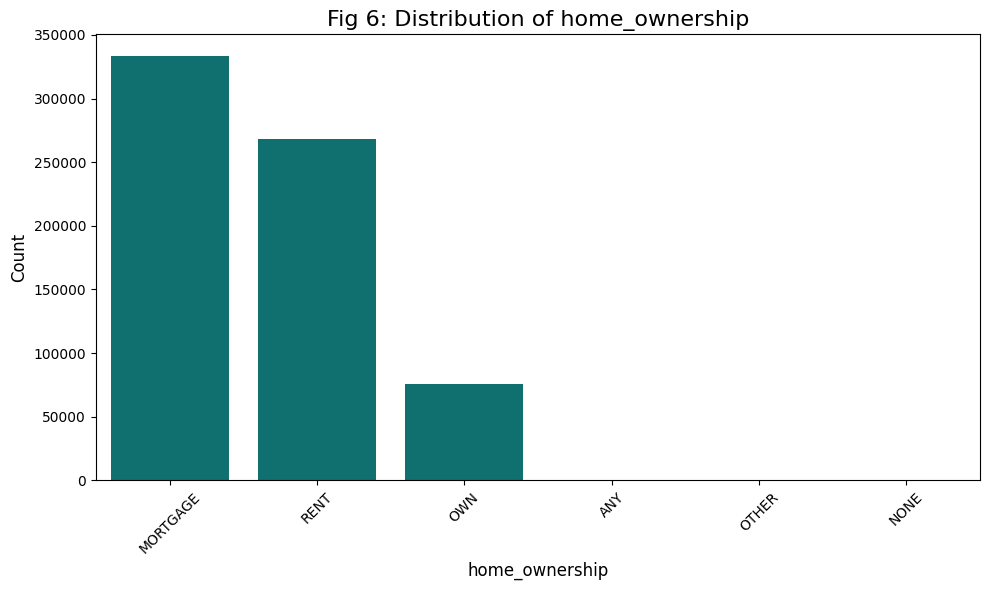

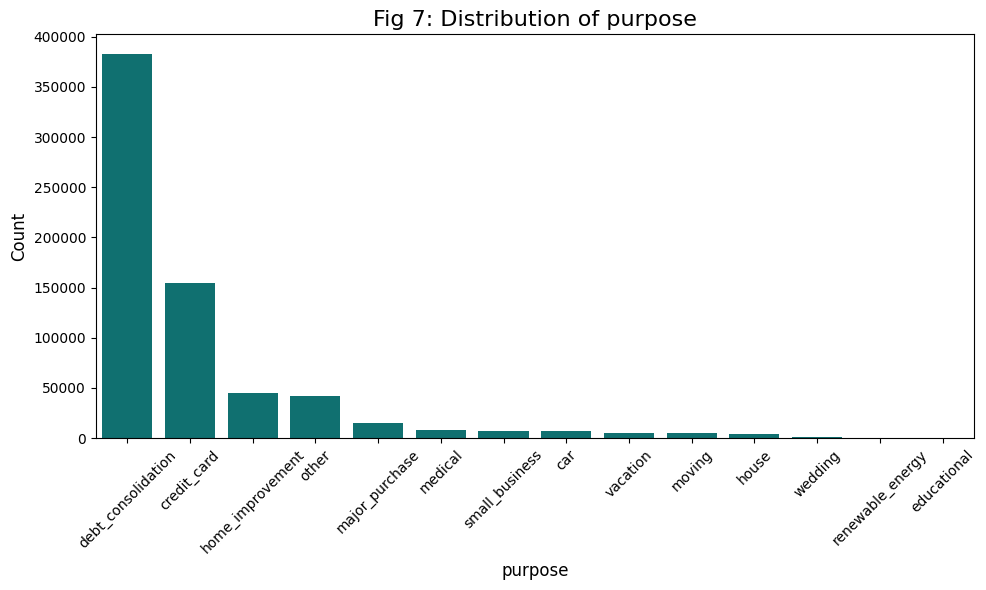

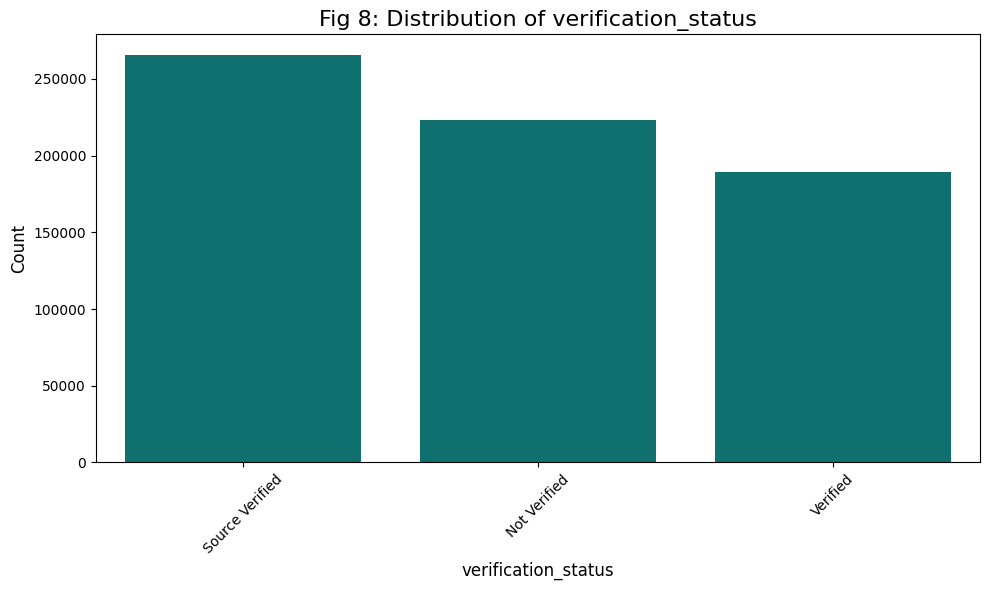

In [19]:
# List of categorical features to analyze
categorical_vars = ['grade', 'home_ownership', 'purpose', 'verification_status']

# Plot distributions of each categorical feature
for i, var in enumerate(categorical_vars, start=5):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=loan_data_sample, x=var, color='teal', order=loan_data_sample[var].value_counts().index)
    plt.title(f"Fig {i}: Distribution of {var}", fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()


**6.3 Target Variable Analysis**

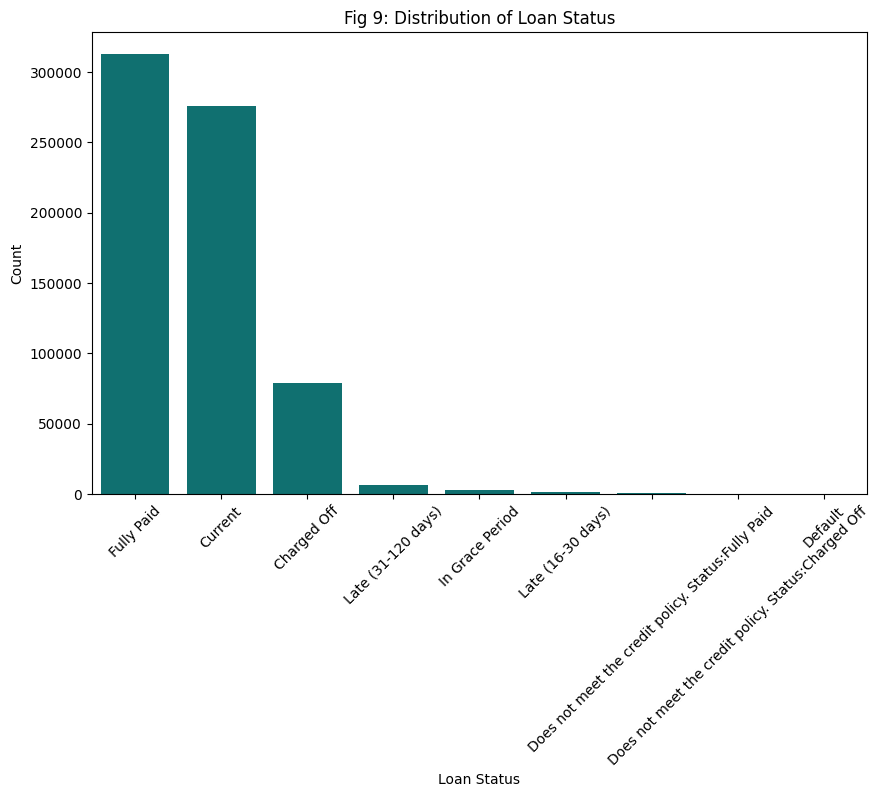

In [20]:
# Visualize loan_status distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_data_sample, x='loan_status', order=loan_data_sample['loan_status'].value_counts().index, color='teal')
plt.title("Fig 9: Distribution of Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Simplify loan_status into two categories: Default (0) and Non-Default (1)
loan_data_sample['loan_status_binary'] = loan_data_sample['loan_status'].map({
    'Fully Paid': 1,
    'Current': 1,
    'Charged Off': 0,
    'Default': 0,
    'Late (31-120 days)': 0,
    'Late (16-30 days)': 0,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Does not meet the credit policy. Status:Charged Off': 0
})

# Check the mapping
print(loan_data_sample['loan_status_binary'].value_counts())

loan_status_binary
1    588786
0     89414
Name: count, dtype: int64


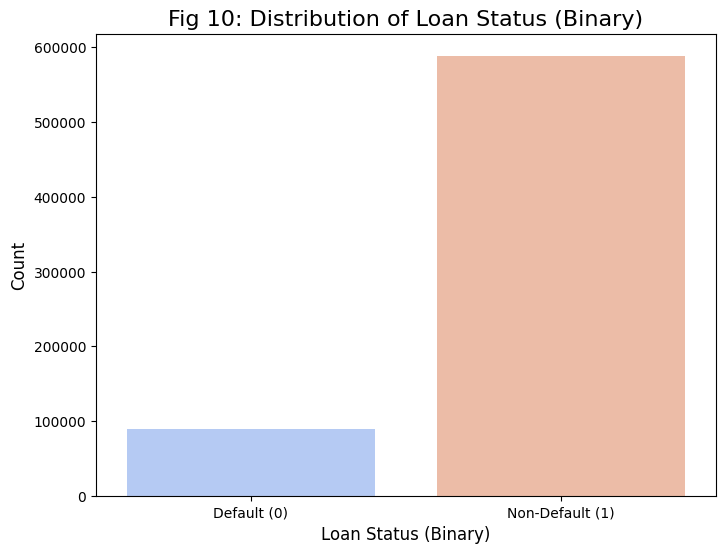

In [22]:
# Plot the distribution of loan_status_binary
plt.figure(figsize=(8, 6))
sns.countplot(data=loan_data_sample, x='loan_status_binary', palette='coolwarm')
plt.title("Fig 10: Distribution of Loan Status (Binary)", fontsize=16)
plt.xlabel("Loan Status (Binary)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Default (0)', 'Non-Default (1)'], fontsize=10)
plt.show()

**6.4 Feature-Target Relationship Analysis**

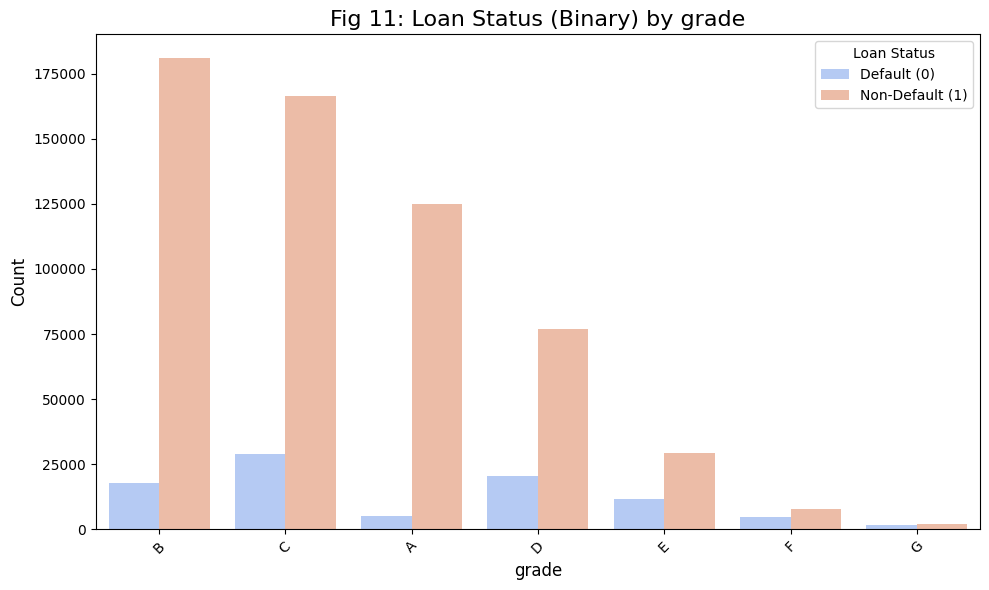

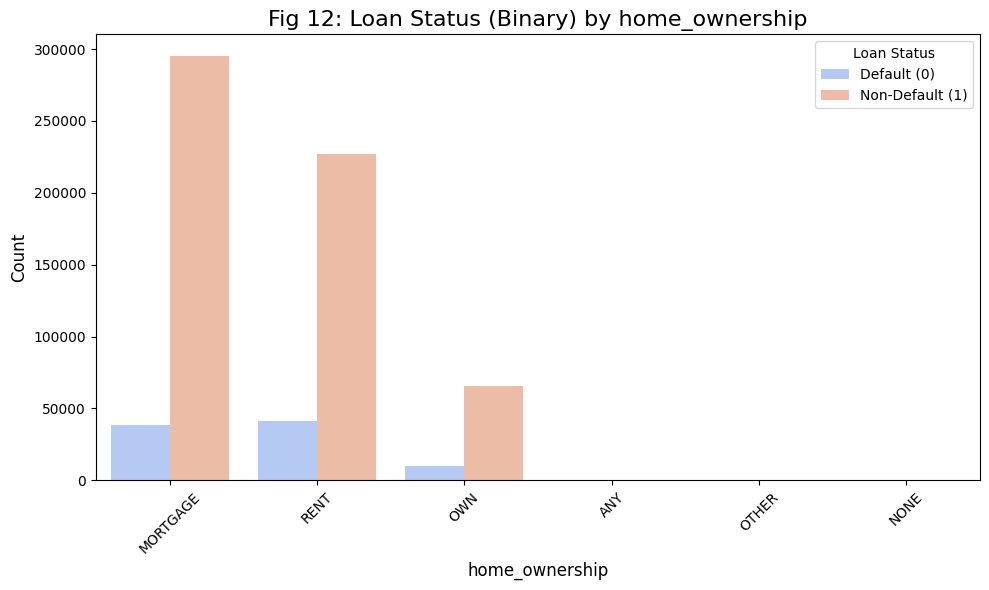

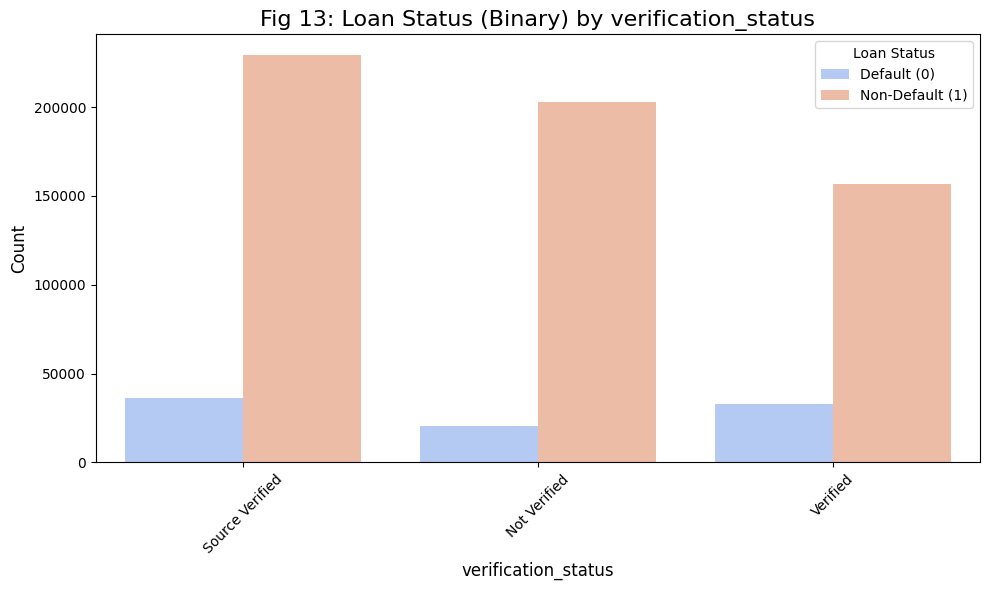

In [23]:
# List of categorical variables to analyze
categorical_vars = ['grade', 'home_ownership', 'verification_status']

# Plot loan_status_binary relationship with each categorical feature
for i, var in enumerate(categorical_vars, start=11):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=loan_data_sample, x=var, hue='loan_status_binary', palette='coolwarm', order=loan_data_sample[var].value_counts().index)
    plt.title(f"Fig {i}: Loan Status (Binary) by {var}", fontsize=16)  # Add figure number to title
    plt.xlabel(var, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title='Loan Status', labels=['Default (0)', 'Non-Default (1)'])
    plt.tight_layout()
    plt.show()


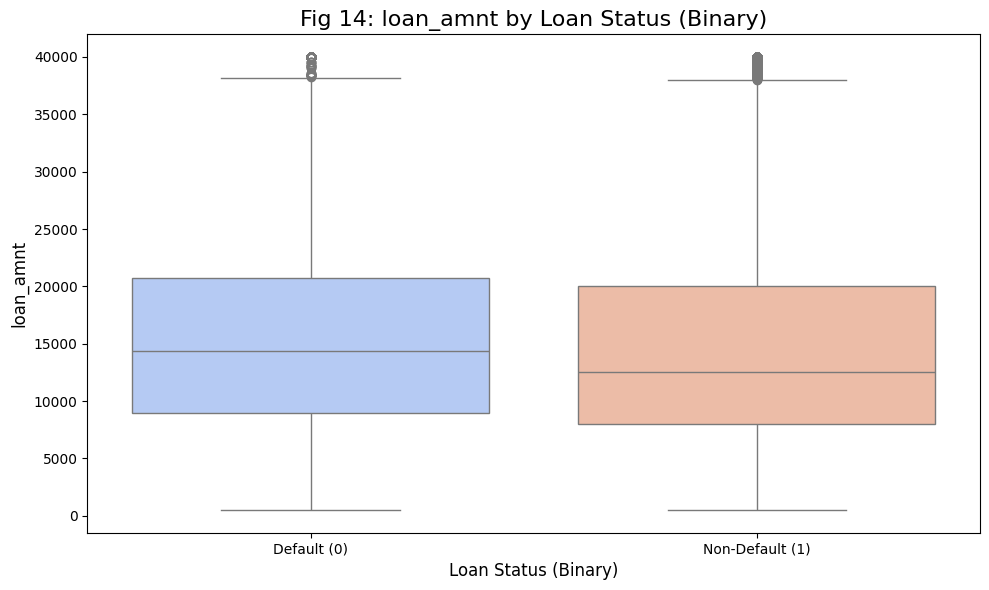

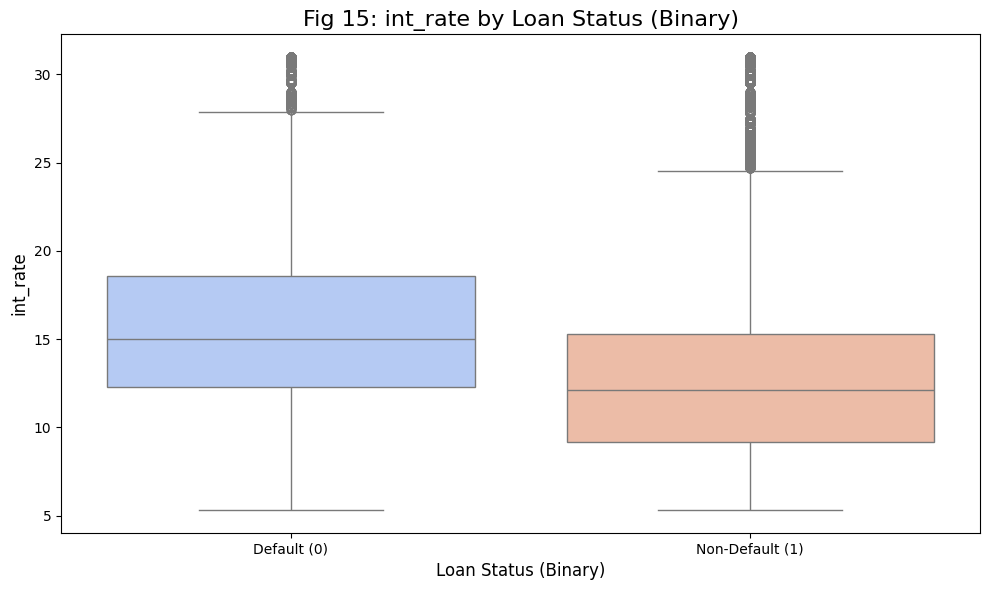

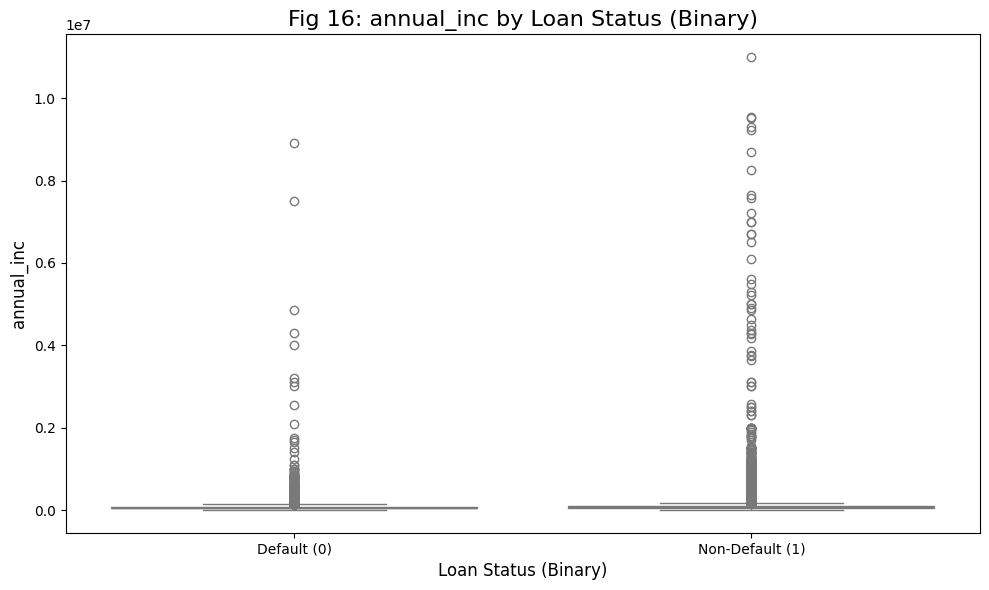

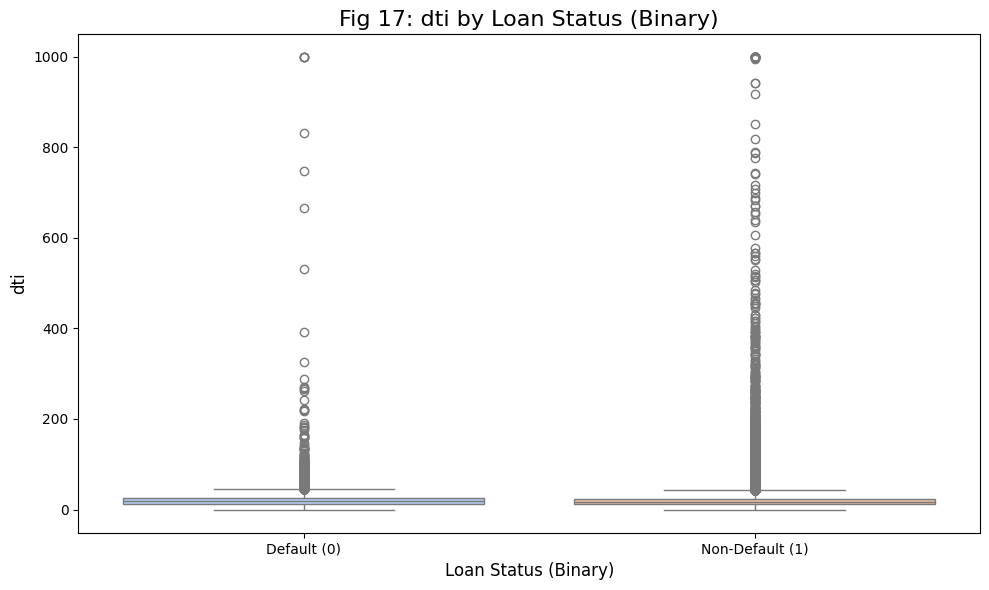

In [24]:
# List of numerical variables to analyze
numerical_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']

# Plot boxplots for each numerical variable with figure labels
for i, var in enumerate(numerical_vars, start=14):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=loan_data_sample, x='loan_status_binary', y=var, palette='coolwarm')
    plt.title(f"Fig {i}: {var} by Loan Status (Binary)", fontsize=16)
    plt.xlabel("Loan Status (Binary)", fontsize=12)
    plt.ylabel(var, fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Default (0)', 'Non-Default (1)'], fontsize=10)
    plt.tight_layout()
    plt.show()

**6.5 Correlation Analysis**

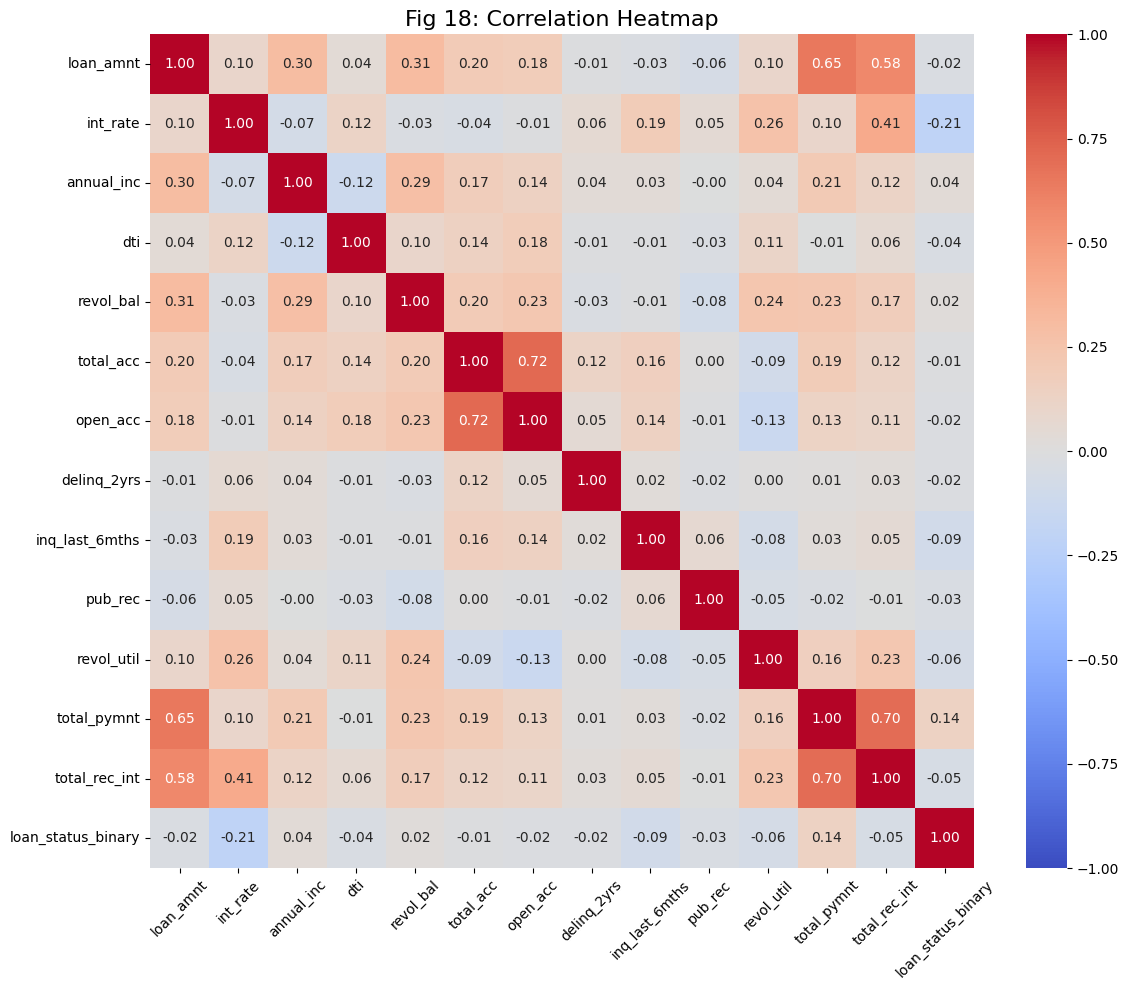

In [25]:
# Select 15 numerical variables (including loan_status_binary)
num_vars = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal',
    'total_acc', 'open_acc', 'delinq_2yrs', 'inq_last_6mths',
    'pub_rec',  'revol_util', 'total_pymnt', 'total_rec_int',
     'loan_status_binary'
]

# Compute correlation matrix
corr_matrix = loan_data_sample[num_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Fig 18: Correlation Heatmap", fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


**6.6 Outlier Handling**

In [26]:
# Handle outliers for all numerical variables
numerical_vars = loan_data_sample.select_dtypes(include=['float64', 'int64']).columns

for var in numerical_vars:
    # Calculate the 1st and 99th percentiles
    lower_threshold = loan_data_sample[var].quantile(0.01)
    upper_threshold = loan_data_sample[var].quantile(0.99)

    # Cap values at the thresholds
    loan_data_sample[var] = loan_data_sample[var].clip(lower=lower_threshold, upper=upper_threshold)


# **7. Feature Engineering**

**7.1 Feature Selection**

In [27]:
# Find highly correlated variable pairs
threshold = 0.7
high_corr = corr_matrix[(corr_matrix > threshold) & (corr_matrix != 1.0)].stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
print(high_corr.sort_values(by='Correlation', ascending=False))


  Variable 1 Variable 2  Correlation
0  total_acc   open_acc     0.717504
1   open_acc  total_acc     0.717504


In [28]:
# Remove the highly correlated variable 'open_acc'
loan_data_sample = loan_data_sample.drop(columns=['open_acc'])

# Output the updated dataset shape and remaining columns
print(f"Removed redundant variable: 'open_acc'")
print(f"Remaining variables: {loan_data_sample.columns.tolist()}")

Removed redundant variable: 'open_acc'
Remaining variables: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal'

In [29]:
# Get the shape of the dataset
print(f"Data Shape: {loan_data_sample.shape}")


Data Shape: (678200, 94)


**7.2 Feature Scaling**

In [30]:
# Exclude the target variable from scaling
numerical_vars = loan_data_sample.select_dtypes(include=['float64', 'int64']).columns
numerical_vars = numerical_vars.drop('loan_status_binary')  # Exclude the target

# Initialize the scaler and scale only the selected numerical variables
scaler = StandardScaler()
loan_data_sample[numerical_vars] = scaler.fit_transform(loan_data_sample[numerical_vars])

**7.3 Encode Categorical Variables**

In [31]:
# Identify all categorical features
categorical_vars = loan_data_sample.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to all categorical variables
for var in categorical_vars:
    loan_data_sample[var] = label_encoder.fit_transform(loan_data_sample[var])

# Output the encoded dataset shape
print(f"Encoded all categorical features. New Data Shape: {loan_data_sample.shape}")

Encoded all categorical features. New Data Shape: (678200, 94)


# **8. Train-Test Split**

In [32]:
# Separate features (X) and target (y)
X = loan_data_sample.drop(columns=['loan_status_binary'])
y = loan_data_sample['loan_status_binary']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shape of the splits
print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")

Training Data Shape: (542560, 93), (542560,)
Testing Data Shape: (135640, 93), (135640,)


# **9. Addressing Class Imbalance**

In [33]:
# Check the class distribution before SMOTE
print(f"Class distribution before SMOTE: {Counter(y_train)}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")


Class distribution before SMOTE: Counter({1: 470872, 0: 71688})
Class distribution after SMOTE: Counter({1: 470872, 0: 470872})


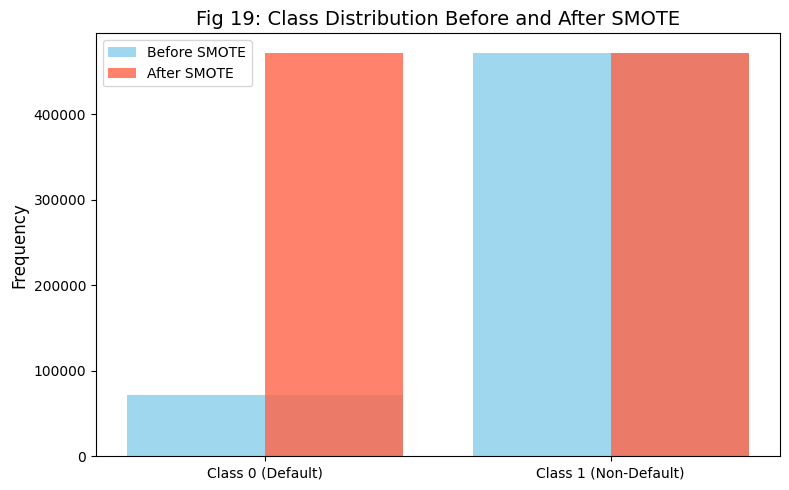

In [34]:
# Example distributions for visualization
before_dist = Counter(y_train)
after_dist = Counter(y_train_resampled)

# Bar plot
plt.figure(figsize=(8, 5))
labels = ['Class 0 (Default)', 'Class 1 (Non-Default)']

# Plot before SMOTE
plt.bar(labels, [before_dist[0], before_dist[1]], color='skyblue', alpha=0.8, label='Before SMOTE')

# Plot after SMOTE
plt.bar(labels, [after_dist[0], after_dist[1]], color='tomato', alpha=0.8, label='After SMOTE', width=0.4, align='edge')

plt.title("Fig 19: Class Distribution Before and After SMOTE", fontsize=14)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


# **10. Model Training and Evaluation**

**10.1 Logistic Regression**

In [35]:
# Initialize logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the resampled training set
log_reg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[ 14719   3007]
 [  6479 111435]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.76     17726
           1       0.97      0.95      0.96    117914

    accuracy                           0.93    135640
   macro avg       0.83      0.89      0.86    135640
weighted avg       0.94      0.93      0.93    135640

ROC-AUC Score:
0.9103775017054283


In [36]:
# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Perform cross-validation
scores_lr = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

# Print mean ROC-AUC score
print(f"Logistic Regression CV ROC-AUC: {scores_lr.mean():.4f}")

Logistic Regression CV ROC-AUC: 0.9411


**10.2 Random Forest**

In [37]:
# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model on the resampled training set
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[ 17712     14]
 [     0 117914]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17726
           1       1.00      1.00      1.00    117914

    accuracy                           1.00    135640
   macro avg       1.00      1.00      1.00    135640
weighted avg       1.00      1.00      1.00    135640

ROC-AUC Score:
0.9999997835076939


In [38]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform cross-validation
scores_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

# Print mean ROC-AUC score
print(f"Random Forest CV ROC-AUC: {scores_rf.mean():.4f}")

Random Forest CV ROC-AUC: 1.0000


**10.3 XGBoost**

In [39]:
# Initialize XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the resampled training set
xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[ 17726      0]
 [     0 117914]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17726
           1       1.00      1.00      1.00    117914

    accuracy                           1.00    135640
   macro avg       1.00      1.00      1.00    135640
weighted avg       1.00      1.00      1.00    135640

ROC-AUC Score:
1.0


In [40]:
# Initialize XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Perform cross-validation
scores_xgb = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

# Print mean ROC-AUC score
print(f"XGBoost CV ROC-AUC: {scores_xgb.mean():.4f}")


XGBoost CV ROC-AUC: 1.0000


# **11. Hyperparameter Tuning**

**11.1 Logistic Regression**

In [41]:
# Define a parameter grid for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [100, 200]
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Set up RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid_lr,
    scoring='roc_auc',       # Use ROC-AUC as the evaluation metric
    cv=2,                    # Use cross-validation of 2 folds
    n_iter=5,                # Test only 5 parameter combinations
    random_state=42,
    n_jobs=1,                # Limit to 1 CPU core to reduce system load
    verbose=1
)

# Perform the search using a smaller dataset
random_search_lr.fit(X_train_resampled.sample(frac=0.5, random_state=42),  # Use 50% of data
                     y_train_resampled.sample(frac=0.5, random_state=42))

# Print the best parameters and score
print("Best Parameters (Logistic Regression):", random_search_lr.best_params_)
print("Best ROC-AUC Score (Logistic Regression):", random_search_lr.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters (Logistic Regression): {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'C': 10}
Best ROC-AUC Score (Logistic Regression): 0.9978846732335078


In [42]:
# Use the best model from RandomizedSearchCV
best_lr = random_search_lr.best_estimator_

# Test set predictions
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[ 16532   1194]
 [   833 117081]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     17726
           1       0.99      0.99      0.99    117914

    accuracy                           0.99    135640
   macro avg       0.97      0.96      0.97    135640
weighted avg       0.98      0.99      0.98    135640


ROC-AUC Score: 0.992342439880364


**11.2 Random Forest**

In [43]:
# Define a parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],                  # Fewer options for tree count
    'max_depth': [10, 20],                       # Limit the range of depths
    'min_samples_split': [2, 5],                 # Reduce the split options
    'min_samples_leaf': [1, 2],                  # Fewer leaf size options
    'bootstrap': [True]                          # Use only one bootstrapping option
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV with reduced settings
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',       # Use ROC-AUC as the evaluation metric
    cv=2,                    # Reduce cross-validation to 2 folds
    n_iter=5,                # Test only 5 parameter combinations
    random_state=42,
    n_jobs=1,                # Limit to 1 CPU core
    verbose=1
)

# Fit the model using a smaller dataset
random_search_rf.fit(X_train.sample(frac=0.5, random_state=42),  # Use 50% of the data
                     y_train.sample(frac=0.5, random_state=42))

# Print the best parameters and score
print("Best Parameters (Random Forest):", random_search_rf.best_params_)
print("Best ROC-AUC Score (Random Forest):", random_search_rf.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
Best ROC-AUC Score (Random Forest): 0.9999993915122045


In [44]:
# Use the best Random Forest model
best_rf = random_search_rf.best_estimator_

# Test set predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score on Test Set:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[ 17709     17]
 [     0 117914]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17726
           1       1.00      1.00      1.00    117914

    accuracy                           1.00    135640
   macro avg       1.00      1.00      1.00    135640
weighted avg       1.00      1.00      1.00    135640


ROC-AUC Score on Test Set: 0.9999999416308039


**11.3 XGBoost**

In [45]:
# Define a simplified parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],              # Fewer options for the number of trees
    'learning_rate': [0.01, 0.1],            # Reduce learning rate choices
    'max_depth': [3, 5],                     # Limit depth range
    'subsample': [0.8],                      # Use a single subsample value
    'colsample_bytree': [0.8]                # Use a single column sampling value
}

# Initialize XGBoost model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Set up RandomizedSearchCV with reduced parameters
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring='roc_auc',        # Use ROC-AUC as the evaluation metric
    cv=2,                     # Reduce cross-validation folds to 2
    n_iter=5,                 # Test only 5 parameter combinations
    verbose=1,
    random_state=42,
    n_jobs=1                  # Limit to 1 CPU core for reduced system load
)

# Perform the search using a smaller dataset
random_search.fit(
    X_train.sample(frac=0.5, random_state=42),  # Use 50% of the data
    y_train.sample(frac=0.5, random_state=42)
)

# Print the best parameters and score
print("Best Parameters (XGBoost):", random_search.best_params_)
print("Best ROC-AUC Score (XGBoost):", random_search.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters (XGBoost): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best ROC-AUC Score (XGBoost): 0.9999999740164374


In [46]:
# Get the best model
best_xgb = random_search.best_estimator_

# Test set predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))


Confusion Matrix:
[[ 17723      3]
 [     0 117914]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17726
           1       1.00      1.00      1.00    117914

    accuracy                           1.00    135640
   macro avg       1.00      1.00      1.00    135640
weighted avg       1.00      1.00      1.00    135640


ROC-AUC Score:
0.9999999966509479


**11.4 Model Comparison**

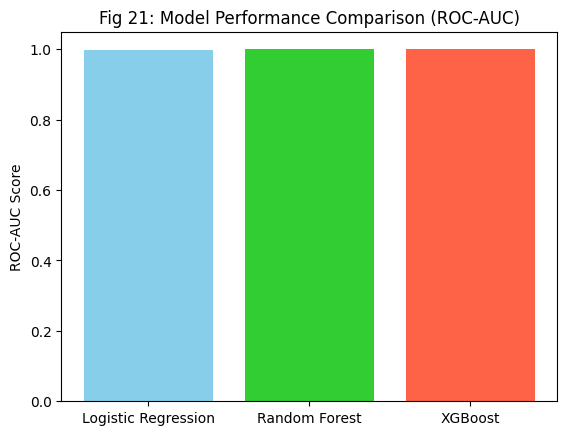

In [47]:
models = ["Logistic Regression", "Random Forest", "XGBoost"]
roc_auc_scores = [random_search_lr.best_score_, random_search_rf.best_score_, random_search.best_score_]
plt.bar(models, roc_auc_scores, color=["skyblue", "limegreen", "tomato"])
plt.title("Fig 21: Model Performance Comparison (ROC-AUC)")
plt.ylabel("ROC-AUC Score")
plt.show()

# **12. Feature Importance**

**12.1 Define the function**

In [50]:
# Function to compute and plot feature importance
def plot_feature_importance(model, model_name, feature_columns, top_n=10):
    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for sorting and visualization
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Print feature importances (full table)
    print(f"Feature Importances for {model_name}:\n", importance_df)

    # Plot top N features
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n], color='teal' if model_name == "Random Forest" else 'purple')
    plt.title(f"Top {top_n} Feature Importances ({model_name})", fontsize=16)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

**12.2 Random Forest**

Feature Importances for Random Forest:
                      Feature  Importance
14               loan_status    0.408091
32                recoveries    0.154708
33   collection_recovery_fee    0.128400
29           total_rec_prncp    0.040377
34              last_pymnt_d    0.034494
..                       ...         ...
39            acc_now_delinq    0.000000
61  chargeoff_within_12_mths    0.000000
62               delinq_amnt    0.000000
81              num_tl_30dpd    0.000000
80          num_tl_120dpd_2m    0.000000

[93 rows x 2 columns]


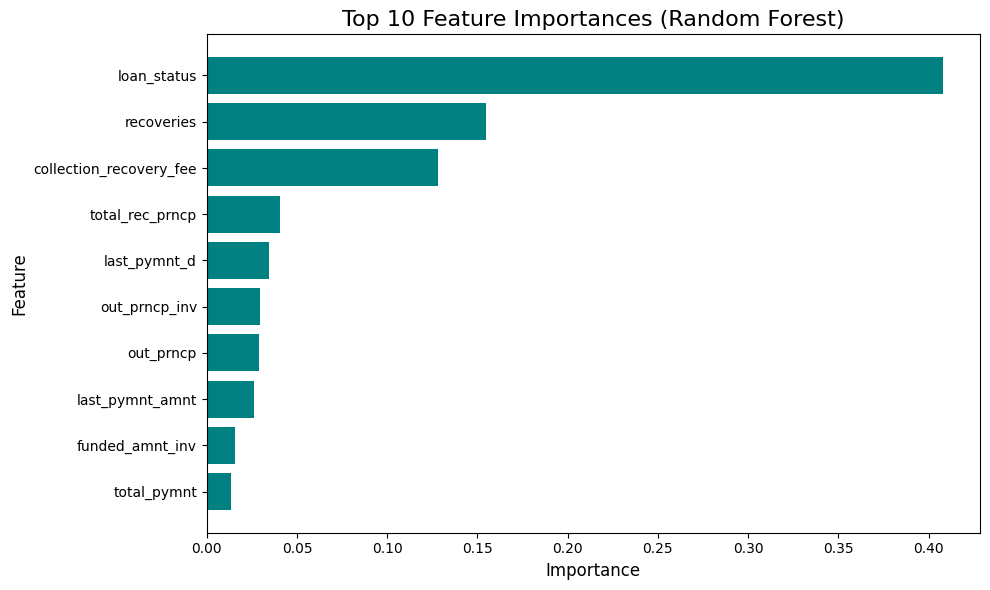

In [51]:
# Call the function for Random Forest
plot_feature_importance(best_rf, "Random Forest", X_train.columns)

**12.3 Xgboost**

Feature Importances for XGBoost:
                        Feature  Importance
14                 loan_status    0.867305
32                  recoveries    0.060746
33     collection_recovery_fee    0.014692
34                last_pymnt_d    0.013372
35             last_pymnt_amnt    0.011087
..                         ...         ...
81                num_tl_30dpd    0.000000
88             tot_hi_cred_lim    0.000000
89           total_bal_ex_mort    0.000000
91  total_il_high_credit_limit    0.000000
92         disbursement_method    0.000000

[93 rows x 2 columns]


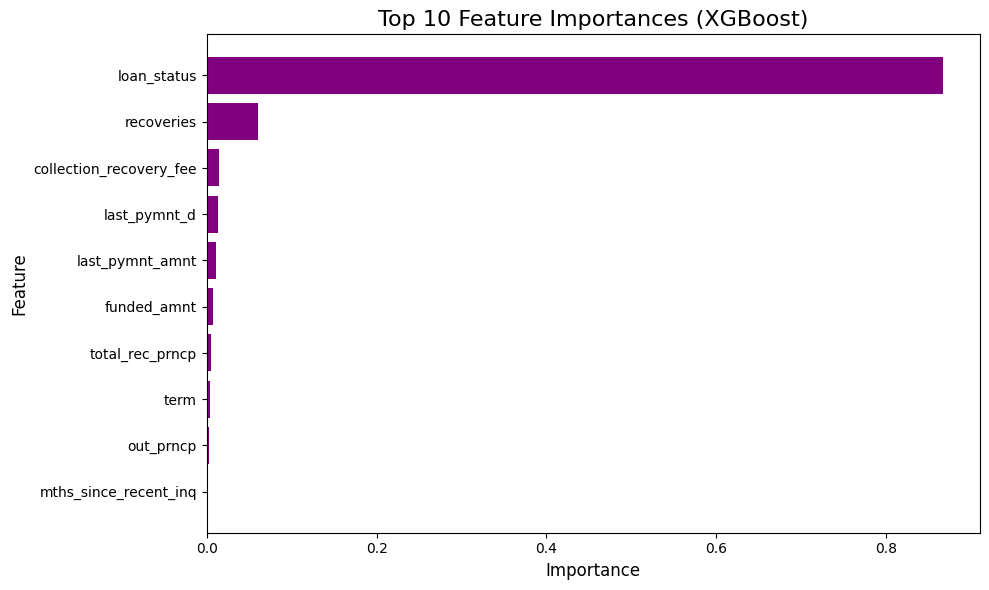

In [52]:
# Call the function for XGBoost
plot_feature_importance(best_xgb, "XGBoost", X_train.columns)

# **13. Flowchart**

In [ ]:
from graphviz import Digraph

# Create a Digraph object
flowchart = Digraph('Loan Default Prediction Workflow', format='png')

# Define nodes for each step
flowchart.node('1', 'Data Loading')
flowchart.node('2', 'Data Cleaning & Preprocessing')
flowchart.node('3', 'Exploratory Data Analysis (EDA)')
flowchart.node('4', 'Handle Class Imbalance (SMOTE)')
flowchart.node('5', 'Train-Test Split')
flowchart.node('6', 'Model Training & Hyperparameter Tuning\n(Logistic Regression, Random Forest, XGBoost)')
flowchart.node('7', 'Model Evaluation\n(Accuracy, Precision, Recall, F1-Score, ROC-AUC)')
flowchart.node('8', 'Analyze Feature Importance')
flowchart.node('9', 'Insights & Recommendations')

# Connect the nodes with arrows
flowchart.edges([
    ('1', '2'),
    ('2', '3'),
    ('3', '4'),
    ('4', '5'),
    ('5', '6'),
    ('6', '7'),
    ('7', '8'),
    ('8', '9')
])

# Save and render the flowchart
flowchart.render('loan_default_workflow', view=True)